In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from pyampute.exploration.mcar_statistical_tests import MCARTest

In [2]:
"""This module contains Python class 'MissForest'."""

__all__ = ["MissForest"]
__version__ = "2.4.2"
__author__ = "Yuen Shing Yan Hindy"

from copy import deepcopy
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from missforest.errors import MultipleDataTypesError, NotFittedError
from typing import Any
from sklearn.base import BaseEstimator
import warnings


class MissForest:
    """
    Parameters
    ----------
    clf : estimator object, default=None.
    This object is assumed to implement the scikit-learn estimator api.

    rgr : estimator object, default=None.
    This object is assumed to implement the scikit-learn estimator api.

     max_iter : int, default=5
     Determines the number of iteration.

     initial_guess : string, callable or None, default='median'
     If ``mean``, the initial imputation will use the median of the features.
     If ``median``, the initial imputation will use the median of the features.
    """

    def __init__(self, clf: Any | BaseEstimator = LGBMClassifier(),
                 rgr: Any | BaseEstimator = LGBMRegressor(verbose=-1),
                 initial_guess: str = 'median', max_iter: int = 5) -> None:
        # make sure the classifier is None (no input) or an estimator.
        if not self._is_estimator(clf):
            raise ValueError("Argument 'clf' only accept estimators that has "
                             "class methods 'fit' and 'predict'.")

        # make sure the regressor is None (no input) or an estimator.
        if not self._is_estimator(rgr):
            raise ValueError("Argument 'rgr' only accept estimators that has"
                             " class methods 'fit' and 'predict'.")

        # make sure 'initial_guess' is str.
        if not isinstance(initial_guess, str):
            raise ValueError("Argument 'initial_guess' only accept str.")

        # make sure 'initial_guess' is either 'median' or 'mean'.
        if initial_guess not in ("median", "mean"):
            raise ValueError("Argument 'initial_guess' can only be 'median' or"
                             " 'mean'.")

        # make sure 'max_iter' is int.
        if not isinstance(max_iter, int):
            raise ValueError("Argument 'max_iter' only accept int.")

        self.classifier = clf
        self.regressor = rgr
        self.initial_guess = initial_guess
        self.max_iter = max_iter
        self._initials = {}
        self._missing_row = {}
        self._obs_row = None
        self._mappings = {}
        self._rev_mappings = {}
        self.categorical = None
        self.numerical = None
        self._all_x_imp_cat = []
        self._all_x_imp_num = []
        self._is_fitted = False
        self.before = -404
        self.after = -404

    @staticmethod
    def _is_estimator(estimator: Any | BaseEstimator) -> bool:
        """
        Class method '_is_estimator_or_none' is used to check if argument
        'estimator' is an object that implement the scikit-learn estimator api.

        Parameters
        ----------
        estimator : estimator object
            This object is assumed to implement the scikit-learn estimator api.

        Return
        ------
        If the argument 'estimator' is None or has class method 'fit' and
        'predict', return True.

        Otherwise, return False
        """

        try:
            # get the class methods 'fit' and 'predict' of the estimator.
            is_has_fit_method = getattr(estimator, "fit")
            is_has_predict_method = getattr(estimator, "predict")

            # check if those class method are callable.
            is_has_fit_method = callable(is_has_fit_method)
            is_has_predict_method = callable(is_has_predict_method)

            # assumes it is an estimator if it has 'fit' and 'predict' methods.
            return is_has_fit_method and is_has_predict_method
        except AttributeError:
            return False

    def _get_missing_rows(self, x: pd.DataFrame) -> None:
        """
        Class method '_get_missing_rows' gather the index of any rows that has
        missing values.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
        Dataset (features only) that needed to be imputed.

        Return
        ------
        miss_row : dict
        Dictionary that contains features which has missing values as keys, and
        their corresponding indexes as values.
        """

        for c in x.columns:
            feature = x[c]
            is_missing = feature.isnull() > 0
            missing_index = feature[is_missing].index
            if len(missing_index) > 0:
                self._missing_row[c] = missing_index

    def _get_obs_row(self, x: pd.DataFrame) -> None:
        """
        Class method '_get_obs_row' gather the rows of any rows that do not
        have any missing values.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
        Dataset (features only) that needed to be imputed.

        Return
        ------
        None
        """

        n_null = x.isnull().sum(axis=1)
        self._obs_row = x[n_null == 0].index

    def _get_map_and_rev_map(self, x: pd.DataFrame, categorical: list
                             ) -> None:
        """
        Class method '_get_map_and_rev_map' gets the encodings and the reverse
        encodings of categorical variables.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
            Dataset (features only) that needed to be imputed.

        categorical : list
            All categorical features of x.

        Return
        ------
        None
        """

        for c in x.columns:
            if c in categorical:
                self.before = len(x[c].dropna())
                unique = x[c].dropna().unique()
                self.after = len(unique)
                n_unique = range(x[c].dropna().nunique())

                self._mappings[c] = dict(zip(unique, n_unique))
                self._rev_mappings[c] = dict(zip(n_unique, unique))

    @staticmethod
    def _check_if_all_single_type(x: pd.DataFrame) -> None:
        """
        Class method '_check_if_all_single_type' checks if all values in the
        feature belongs to the same datatype. If not, error
        'MultipleDataTypesError will be raised.'

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
        Dataset (features only) that needed to be imputed.
        """

        vectorized_type = np.vectorize(type)
        for c in x.columns:
            feature_no_na = x[c].dropna()
            all_type = vectorized_type(feature_no_na)
            all_unique_type = pd.unique(all_type)
            n_type = len(all_unique_type)
            if n_type > 1:
                raise MultipleDataTypesError(f"Feature {c} has more than one "
                                             f"datatype.")

    def _get_initials(self, x: pd.DataFrame, categorical: list) -> None:
        """
        Class method '_initial_imputation' calculates and stores the initial
        imputation values of each features in x.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
        Dataset (features only) that needed to be imputed.

        categorical : list
        All categorical features of x.

        Return
        ------
        None
        """

        intersection = set(categorical).intersection(set(x.columns))
        if not intersection == set(categorical):
            raise ValueError("Not all features in argument 'categorical' "
                             "existed in 'x' columns.")

        for c in x.columns:
            if c in categorical:
                self._initials[c] = x[c].mode().values[0]
            else:
                if self.initial_guess == "mean":
                    self._initials[c] = x[c].mean()
                elif self.initial_guess == "median":
                    self._initials[c] = x[c].median()
                else:
                    raise ValueError("Argument 'initial_guess' only accepts "
                                     "'mean' or 'median'.")

    def _initial_imputation(self, x: pd.DataFrame) -> pd.DataFrame:
        """Class method '_initial_imputation' imputes the values of features
        using the mean or median if they are numerical variables, else, imputes
        with mode.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
            Dataset (features only) that needed to be imputed.

        Return
        ------
        x : pd.DataFrame of shape (n_samples, n_features)
            Imputed Dataset (features only).
        """

        for c in x.columns:
            x[c].fillna(self._initials[c], inplace=True)

        return x

    @staticmethod
    def _label_encoding(x: pd.DataFrame, mappings: dict) -> pd.DataFrame:
        """
        Class method '_label_encoding' performs label encoding on given
        features and the input mappings.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
            Dataset (features only) that needed to be imputed.

        mappings : dict
            Dictionary that contains the categorical variables as keys and
            their corresponding encodings as values.

        Return
        ------
        x : pd.DataFrame of shape (n_samples, n_features)
            Label-encoded dataset (features only).
        """

        for c in mappings:
            x[c] = x[c].map(mappings[c]).astype(int)

        return x

    @staticmethod
    def _rev_label_encoding(x: pd.DataFrame, rev_mappings: dict
                            ) -> pd.DataFrame:
        """
        Class method '_rev_label_encoding' performs reverse label encoding on
        given features and the input reverse mappings.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
            Dataset (features only) that needed to be imputed.

        rev_mappings : dict
            Dictionary that contains the categorical variables as keys and
            their corresponding encodings as values.

        Return
        ------
        x : pd.DataFrame of shape (n_samples, n_features)
            Reverse label-encoded dataset (features only).
        """

        for c in rev_mappings:
            x[c] = x[c].map(rev_mappings[c])

        return x

    def _add_unseen_categories(self, x, mappings):
        """
        Class method '_add_unseen_categories' updates mappings and reverse
        mappings, if there are any unseen categories.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
            Dataset (features only) that needed to be imputed.

        mappings : dict
            Dictionary that contains the categorical variables as keys and
            their corresponding encodings as values.

        Return
        ------
        rev_mappings : dict
            Dictionary that contains the categorical variables as keys and
            their corresponding encodings as values.

        mappings : dict
            Dictionary that contains the categorical variables as keys and
            their corresponding encodings as values.
        """

        for k, v in mappings.items():
            for category in x[k].unique():
                if category not in v:
                    warnings.warn("Unseen category found in dataset. New label"
                                  " will be added.")
                    mappings[k][category] = max(v.values()) + 1

        rev_mappings = {k: {v2: k2 for k2, v2 in v.items()} for k, v in mappings.items()}

        self._mappings, self._rev_mappings =  mappings, rev_mappings

    def fit(self, x: pd.DataFrame, categorical: list = None):
        """
        Class method 'fit' checks if the arguments are valid and initiates
        different class attributes.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
        Dataset (features only) that needed to be imputed.

        categorical : list, default=None
        All categorical features of x.

        Return
        ------
        x : pd.DataFrame of shape (n_samples, n_features)
        Reverse label-encoded dataset (features only).
        """

        x = x.copy()

        # make sure 'x' is either pandas dataframe, numpy array or list of
        # lists.
        if (
                not isinstance(x, pd.DataFrame) and
                not isinstance(x, np.ndarray) and
                not (
                        isinstance(x, list) and
                        all(isinstance(i, list) for i in x)
                )
        ):
            raise ValueError("Argument 'x' can only be pandas dataframe, numpy"
                             " array or list of list.")

        # if 'x' is a list of list, convert 'x' into a pandas dataframe.
        if (
                isinstance(x, np.ndarray) or
                (isinstance(x, list) and all(isinstance(i, list) for i in x))
        ):
            x = pd.DataFrame(x)

        # make sure 'categorical' is a list of str.
        if (
                categorical is not None and
                not isinstance(categorical, list) and
                not all(isinstance(elem, str) for elem in categorical)
        ):
            raise ValueError("Argument 'categorical' can only be list of "
                             "str or NoneType.")

        # make sure 'categorical' has at least one variable in it.
        if categorical is not None and len(categorical) < 1:
            raise ValueError(f"Argument 'categorical' has a len of "
                             f"{len(categorical)}.")

        # Check for +/- inf
        if (
                categorical is not None and
                np.any(np.isinf(x.drop(categorical, axis=1)))
        ):
            raise ValueError("+/- inf values are not supported.")

        # make sure there is no column with all missing values.
        if np.any(x.isnull().sum() == len(x)):
            raise ValueError("One or more columns have all rows missing.")

        self._initials = {}
        self._missing_row = {}
        self._obs_row = None
        self._mappings = {}
        self._rev_mappings = {}

        if categorical is None:
            categorical = []

        self.categorical = categorical
        self.numerical = [c for c in x.columns if c not in categorical]

        self._check_if_all_single_type(x)
        self._get_map_and_rev_map(x, categorical)
        self._get_initials(x, categorical)
        self._is_fitted = True

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """
        Class method 'transform' imputes all missing values in 'x'.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
            Dataset (features only) that needed to be imputed.

        Return
        ------
        x : pd.DataFrame of shape (n_samples, n_features)
            Imputed dataset (features only).
        """

        if not self._is_fitted:
            raise NotFittedError("MissForest is not fitted yet.")

        x = x.copy()
        if x.isnull().sum().sum() == 0:
            raise ValueError("'x' must have at least one missing value.")

        self._get_missing_rows(x)
        self._get_obs_row(x)
        x_imp = self._initial_imputation(x)
        self._add_unseen_categories(x_imp, self._mappings)
        x_imp = self._label_encoding(x_imp, self._mappings)

        all_gamma_cat = []
        all_gamma_num = []
        n_iter = 0
        while True:
            for c in self._missing_row:
                if c in self._mappings:
                    estimator = deepcopy(self.classifier)
                else:
                    estimator = deepcopy(self.regressor)

                # Fit estimator with imputed x
                x_obs = x_imp.drop(c, axis=1).loc[self._obs_row]
                y_obs = x_imp[c].loc[self._obs_row]
                estimator.fit(x_obs, y_obs)

                # Predict the missing column with the trained estimator
                miss_index = self._missing_row[c]
                x_missing = x_imp.loc[miss_index]
                x_missing = x_missing.drop(c, axis=1)
                y_pred = estimator.predict(x_missing)
                y_pred = pd.Series(y_pred)
                y_pred.index = self._missing_row[c]

                # Update imputed matrix
                x_imp.loc[miss_index, c] = y_pred

                self._all_x_imp_cat.append(
                    x_imp[self.categorical].reset_index(drop=False))
                self._all_x_imp_num.append(
                    x_imp[self.numerical].reset_index(drop=False))
                

            if len(self.categorical) > 0 and len(self._all_x_imp_cat) >= 2:
                x_imp_cat = self._all_x_imp_cat[-1]
                x_imp_cat_prev = self._all_x_imp_cat[-2]
                gamma_cat = (np.sum(np.sum(
                    x_imp_cat != x_imp_cat_prev, axis=0
                ),  axis=0) / len(self.categorical))
                all_gamma_cat.append(gamma_cat)

            if len(self.numerical) > 0 and len(self._all_x_imp_num) >= 2:
                x_imp_num = self._all_x_imp_num[-1]
                x_imp_num_prev = self._all_x_imp_num[-2]
                gamma_num = (np.sum(np.sum(
                    (x_imp_num - x_imp_num_prev) ** 2, axis=0
                ), axis=0) / np.sum(np.sum(x_imp_num ** 2, axis=0), axis=0))
                all_gamma_num.append(gamma_num)

            n_iter += 1
            if n_iter > self.max_iter:
                break

            if (
                    n_iter >= 2 and
                    len(self.categorical) > 0 and
                    len(all_gamma_cat) >= 2 and
                    all_gamma_cat[-1] > all_gamma_cat[-2]
            ):
                break

            if (
                    n_iter >= 2 and
                    len(self.numerical) > 0 and
                    len(all_gamma_cat) >= 2 and
                    all_gamma_num[-1] > all_gamma_num[-2]
            ):
                break

        # mapping the encoded values back to its categories.
        x = self._rev_label_encoding(x_imp, self._rev_mappings)
        
        return x

    def fit_transform(self, x: pd.DataFrame, categorical: list = None
                      ) -> pd.DataFrame:
        """
        Class method 'fit_transform' calls class method 'fit' and 'transform'
        on 'x'.

        Parameters
        ----------
        x : pd.DataFrame of shape (n_samples, n_features)
        Dataset (features only) that needed to be imputed.

        categorical : list, default=None
        All categorical features of x.

        Return
        ------
        x : pd.DataFrame of shape (n_samples, n_features)
        Imputed dataset (features only).
        """

        self.fit(x, categorical)
        x = self.transform(x)

        return x


In [3]:
columns_to_to_removed = ['Solvent','CHEM21', 'CHEM21 Numerical', 'Functional Group', 'Grignard', 'Amide Coupling 1', 'Amide Coupling 2','Heck', 'Baylis-Hillman', 'Suzuki-Miyaura Pd','Suzuki-Miyaura Ni', 'Buchwald-Hartwig', 'Alkene Metathesis', 'SNAr', 'cost', 'Alternative Name','Cas Number' ]

data = pd.read_csv(r'C:\Users\dadab\comp_data\updated_datasets\updated_with_all_viscosity_values.csv', index_col=0).drop(columns_to_to_removed, axis = 'columns')

#data.replace('', 0, inplace = True)
data

,Molecular Weight,Boiling Point,Melting Point,Density,Viscosity,Vapor Pressure,Refractive Index,LogP,Dipole Moment,Dielectric Constant,Alpha,Beta,Pi,Dispersion,Polarity,H Bonding,Molar Volume
0,98.96,83.4,-35.6,1.2454,0.7800,78.8900,1.4422,1.48,1.27,10.74,0.000000,0.10000,0.810000,19.0,7.4,4.1,79.460093
1,90.12,85.0,-58.0,0.8630,0.4859,48.0000,1.3813,-0.21,1.71,7.20,0.000000,0.41000,0.530000,15.4,6.3,6.0,104.426419
2,76.10,124.1,-85.1,0.9647,1.5440,9.5000,1.4024,-0.77,2.04,16.93,0.264706,0.41902,0.624717,16.2,9.2,16.4,78.879444
3,60.05,117.9,16.6,1.0446,1.0560,15.7000,1.3720,-0.17,1.70,6.20,1.120000,0.45000,0.640000,14.5,8.0,13.5,57.488417
4,102.09,139.5,-73.4,1.0820,0.8430,5.1100,1.3901,-0.27,2.80,20.70,0.000000,0.29000,0.760000,16.0,11.7,10.2,94.352680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,118.10,150.2,NaN,0.8886,NaN,2.2125,1.4130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,146.09,168.5,NaN,0.9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366,216.17,257.5,-50.0,0.9500,NaN,NaN,NaN,3.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,206.15,278.0,-35.0,0.9800,NaN,0.0025,1.4389,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


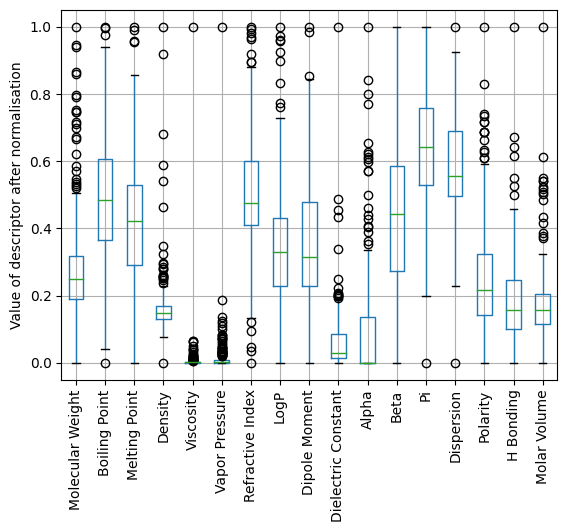

In [7]:

scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.fit_transform(data)
#print(scaled_data)

df = pd.DataFrame(scaled_data, columns = data.columns)
fig, ax = plt.subplots()
df.boxplot(column = list(df.columns), rot = 90, figsize =(9,9))
plt.ylabel("Value of descriptor after normalisation")
plt.show()
fig.savefig('value_boxplots_scaled' + '.pdf', bbox_inches = 'tight')

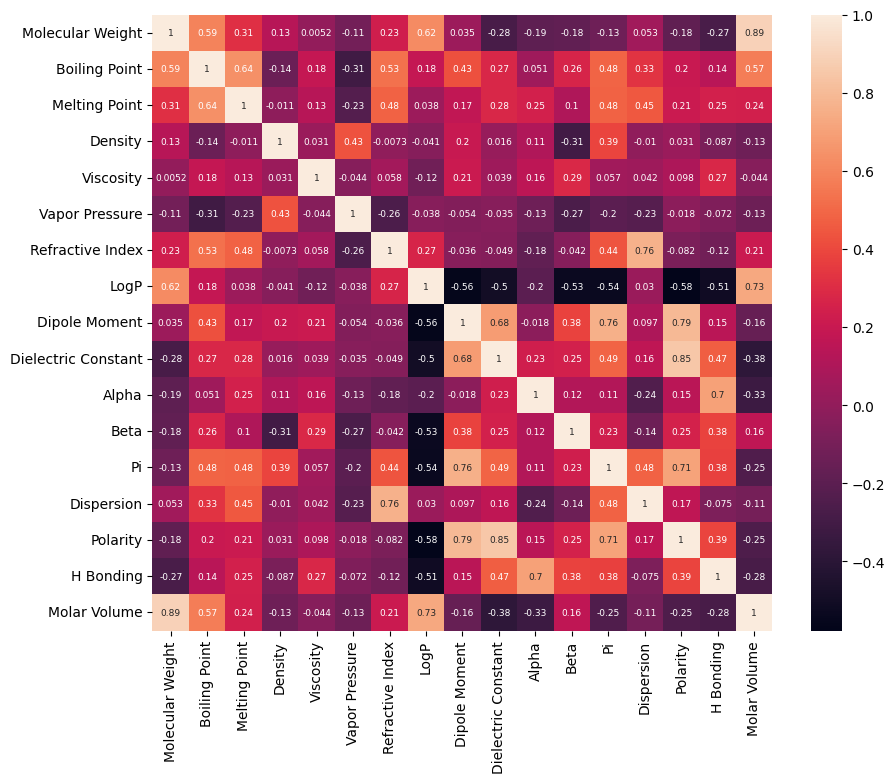

In [5]:
correlation_data = df.corr()

fig, ax  = plt.subplots(figsize = (10, 8))

correlation_data_heatmap = sns.heatmap(correlation_data, annot = True, annot_kws={"size": 6.5})

fig.savefig('correlation_heatmap_1.pdf', bbox_inches = 'tight')

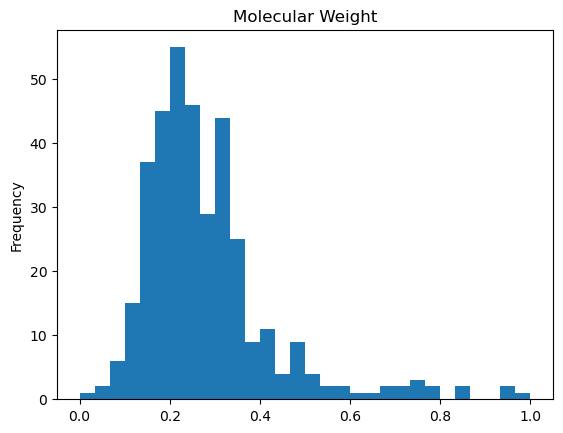

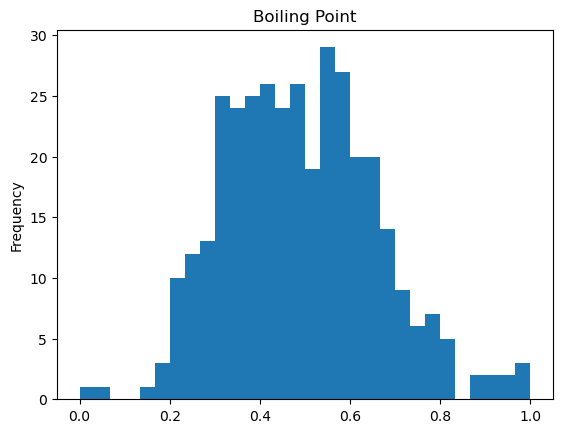

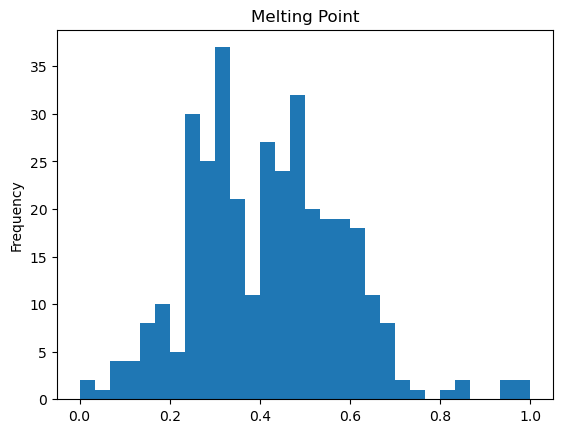

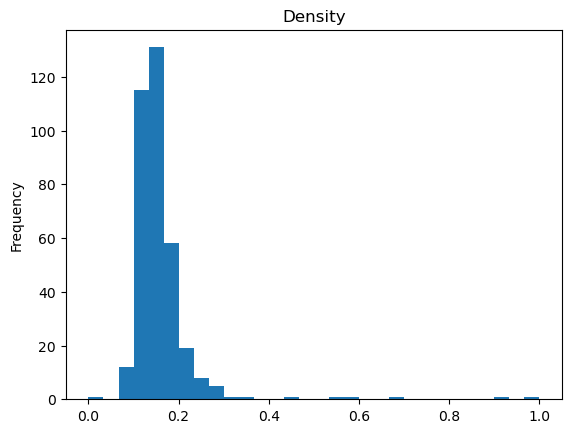

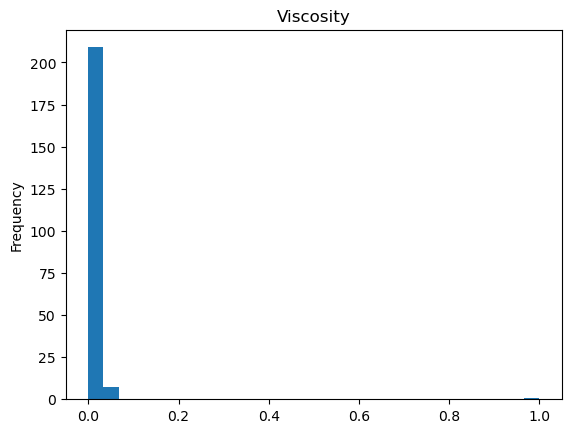

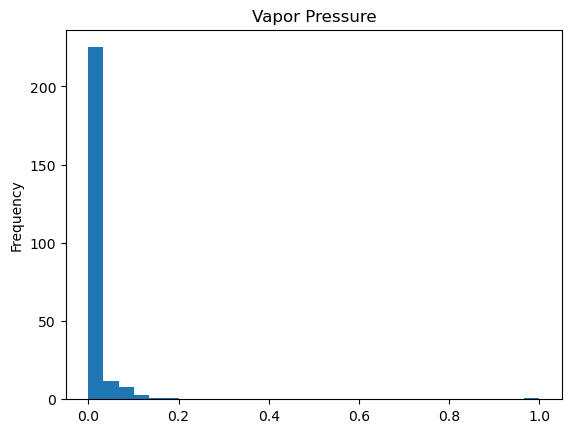

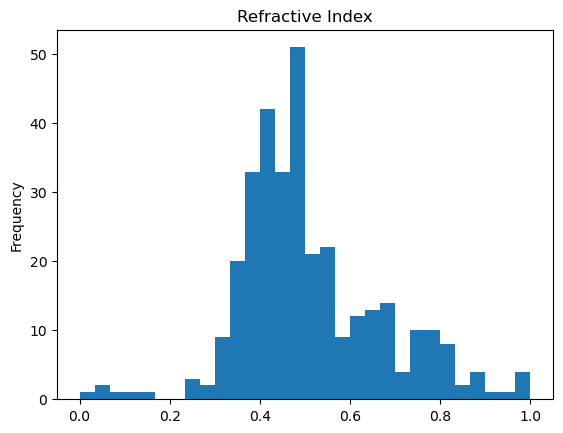

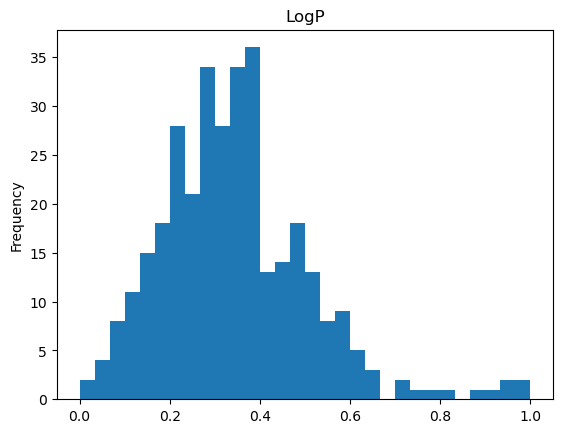

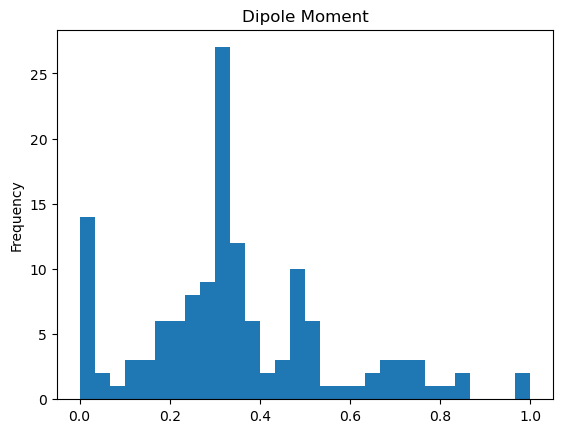

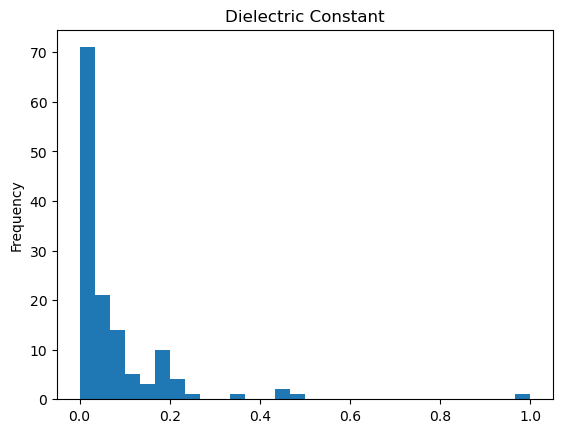

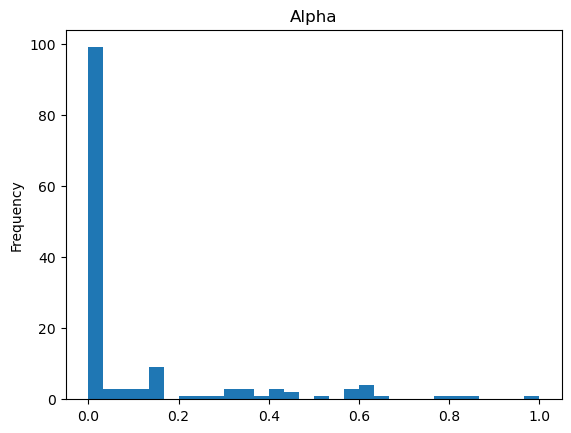

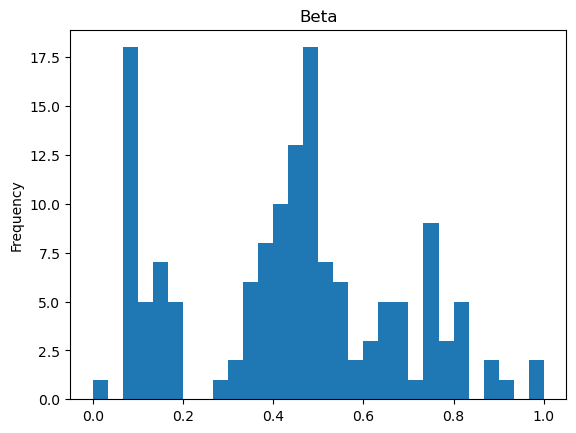

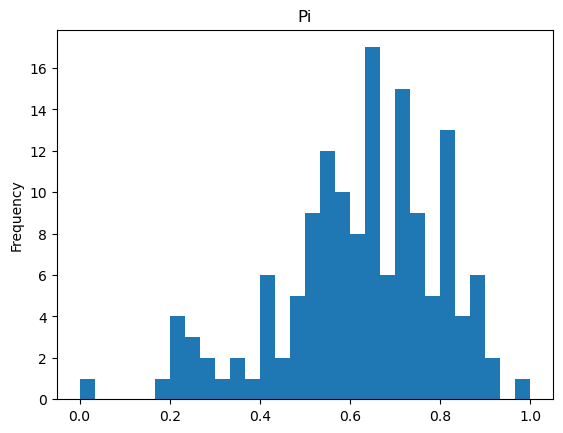

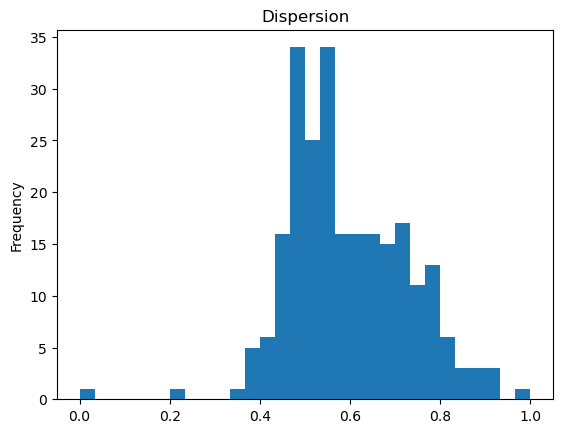

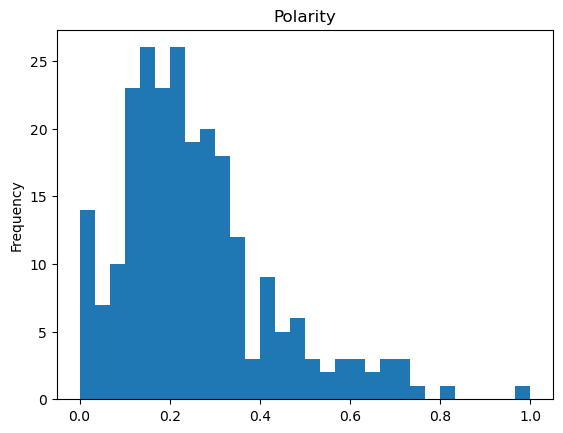

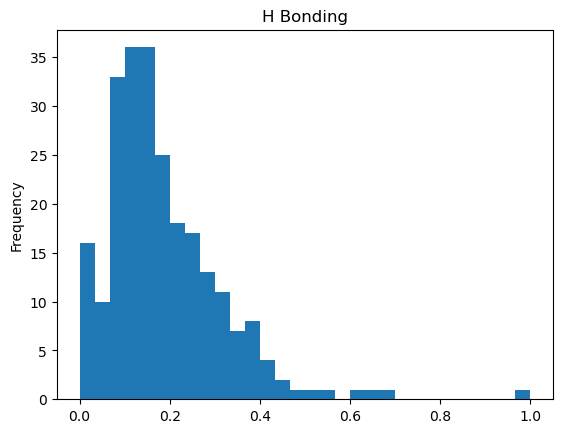

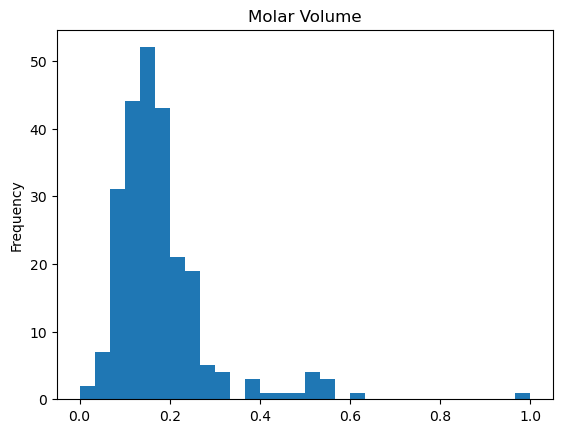

In [7]:
for i in df:
    fig, ax = plt.subplots()
    hist = df.hist(i, bins = 30, ax=ax)
    #if i is 'Viscosity':
      #  plt.xlim()
    plt.grid(False)
    plt.ylabel("Frequency")
    plt.show()
    fig.savefig('first_histograms_' + i +'.png')

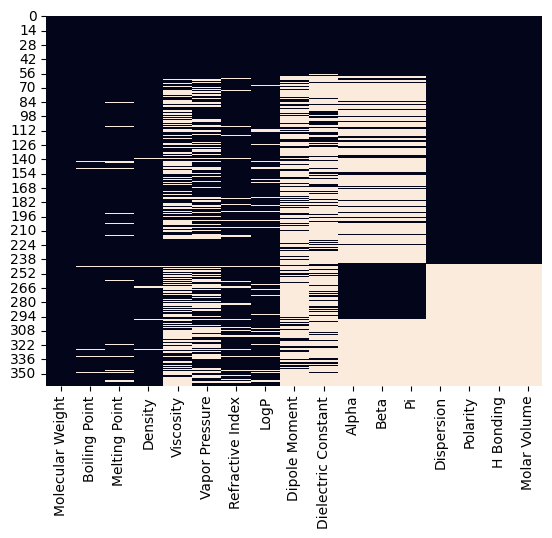

<Figure size 640x480 with 0 Axes>

In [5]:
#missingness = msno.matrix(data)
heat_map_sns = sns.heatmap(df.isnull(), cbar=False)
plt.show()
plt.savefig('missing_matrix'+'.png', bbox_inches = 'tight')


In [24]:
df.isnull().sum()/len(df)*100

Molecular Weight        0.000000
Boiling Point           1.657459
Melting Point           4.419890
Density                 1.381215
Viscosity              40.055249
Vapor Pressure         30.662983
Refractive Index        7.734807
LogP                    8.011050
Dipole Moment          61.878453
Dielectric Constant    62.983425
Alpha                  59.944751
Beta                   59.944751
Pi                     59.944751
Dispersion             32.872928
Polarity               32.872928
H Bonding              32.872928
Molar Volume           32.872928
dtype: float64

In [4]:
df.isnull().sum()

Molecular Weight         0
Boiling Point            6
Melting Point           16
Density                  5
Viscosity              145
Vapor Pressure         111
Refractive Index        28
LogP                    29
Dipole Moment          224
Dielectric Constant    228
Alpha                  217
Beta                   217
Pi                     217
Dispersion             119
Polarity               119
H Bonding              119
Molar Volume           119
dtype: int64

In [54]:
for x in data.columns:
    range_viscosity = data[x].max() - data[x].min()
    print(f'The range of {x} {range_viscosity}')


         
        


The range of Molecular Weight 372.26
The range of Boiling Point 429.0
The range of Melting Point 290.0
The range of Density 4.9159999999999995
The range of Viscosity 944.9895
The range of Vapor Pressure 7250.0
The range of Refractive Index 0.38883
The range of LogP 10.62
The range of Dipole Moment 5.58
The range of Dielectric Constant 180.6
The range of Alpha 1.96
The range of Beta 1.1300000000000001
The range of Pi 1.6099999999999999
The range of Dispersion 11.9
The range of Polarity 26.2
The range of H Bonding 42.3
The range of Molar Volume 594.89427136


In [6]:
#data_mcar = pd.read_table(".csv")
data.replace('', np.nan)
mt = MCARTest(method="little")
print(mt.little_mcar_test(data))

1.0


In [18]:
df_imputed.to_csv('scaled_imputted_data_1.csv')

In [11]:
df.replace('', np.nan)
mf = MissForest()
mf.fit(df)
df_imputed = mf.transform(df)
print(mf.before, mf.after)

df_imputed
output = scaler.inverse_transform(df_imputed)
output_df = pd.DataFrame(output, columns = df_imputed.columns)
output_df.to_csv('MinMax_scaled_imputted_data_1.csv')


-404 -404


In [16]:
print(output_df.index.values)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [20]:
imputted_values = pd.read_csv('scaled_imputted_data_1.csv')
all_values = pd.read_csv('updated_datasets/updated_with_all_viscosity_values.csv')

imputted_values = imputted_values.join(all_values['Solvent'], how='left')
imputted_values.to_csv('updated_datasets/joined_data_values_1.csv')



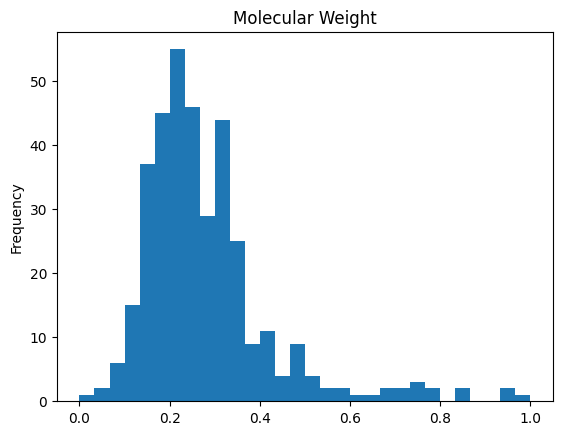

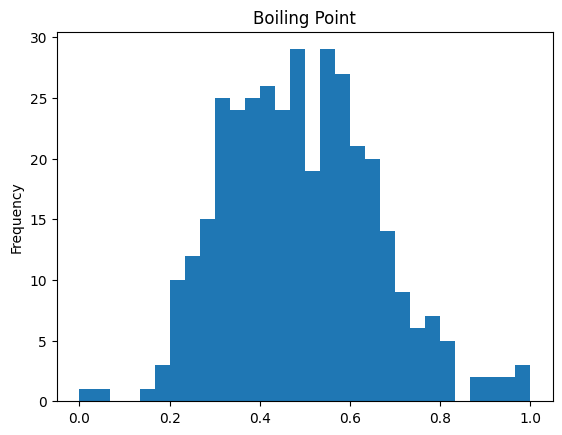

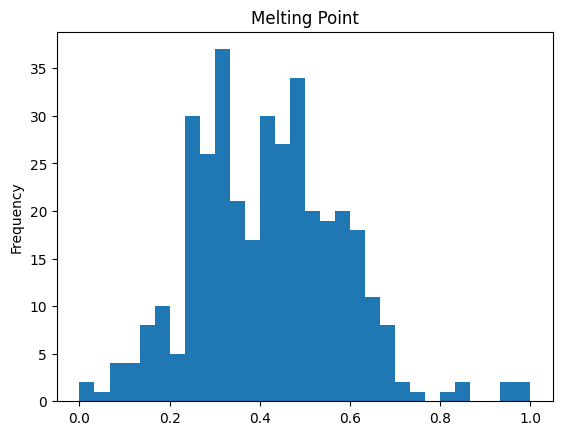

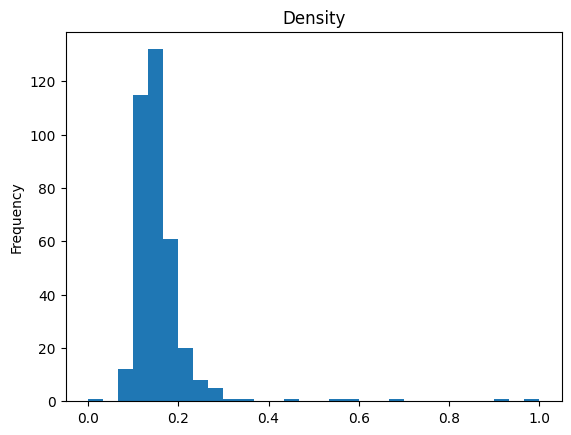

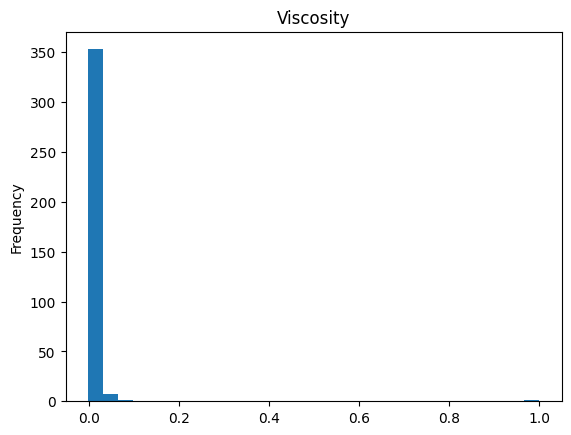

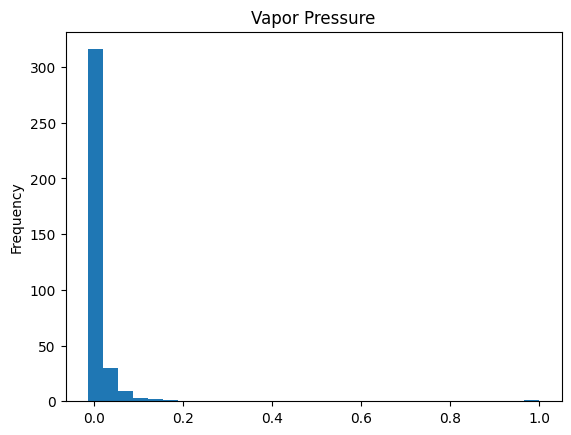

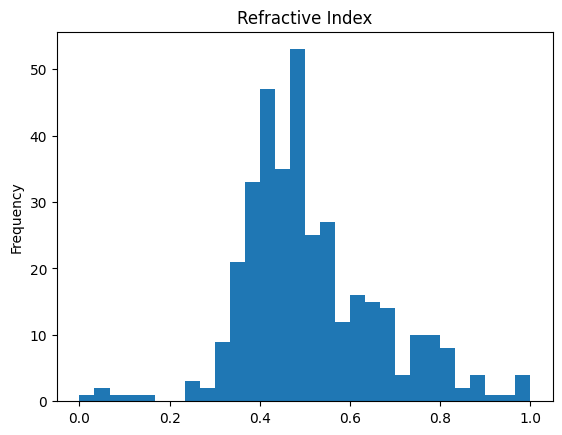

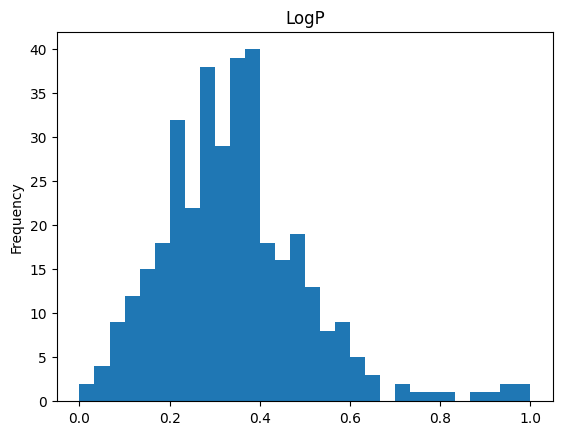

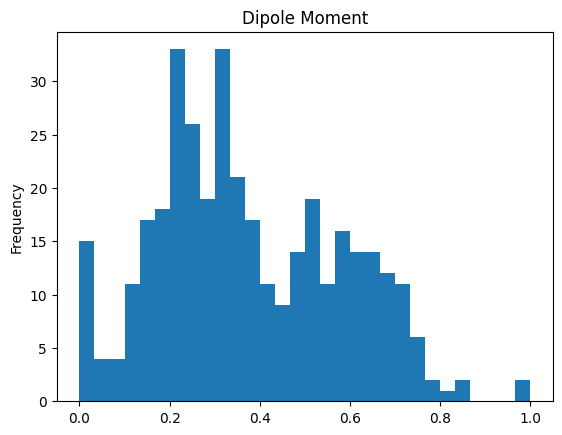

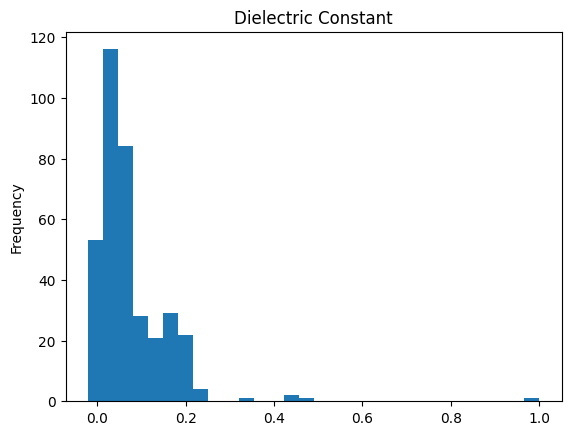

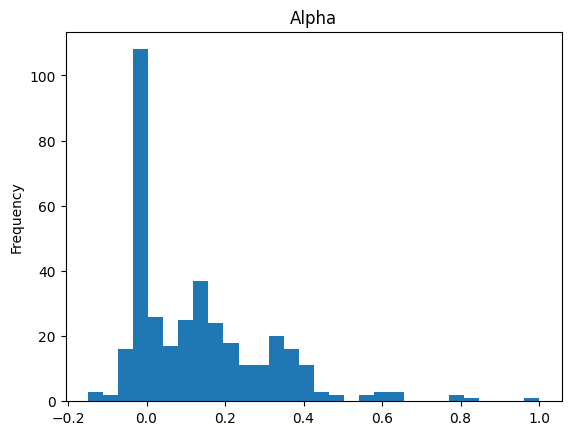

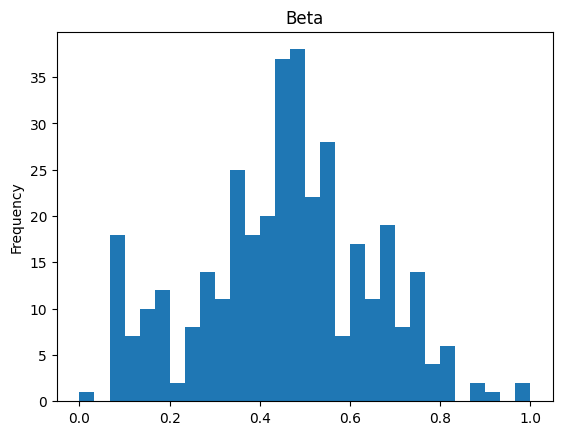

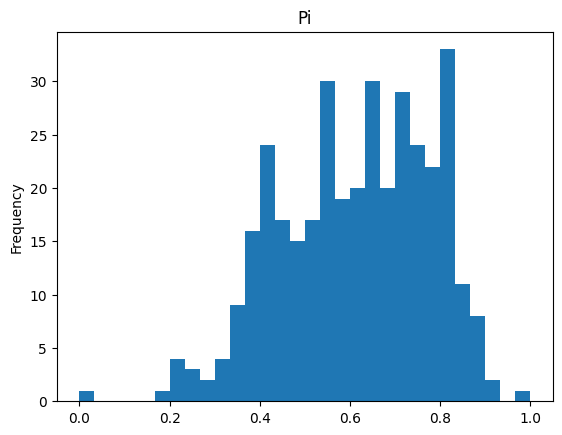

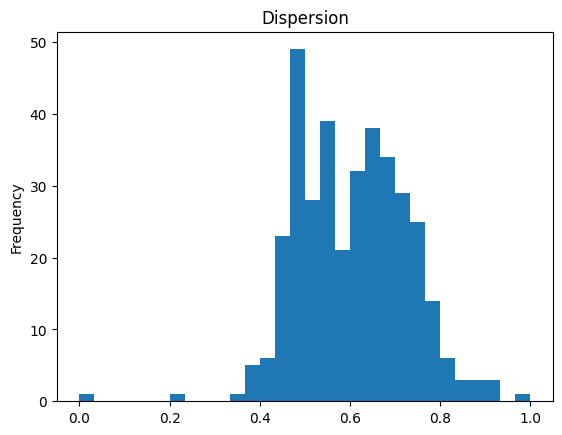

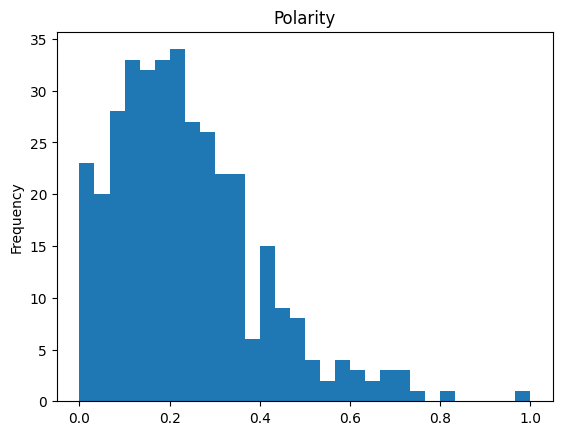

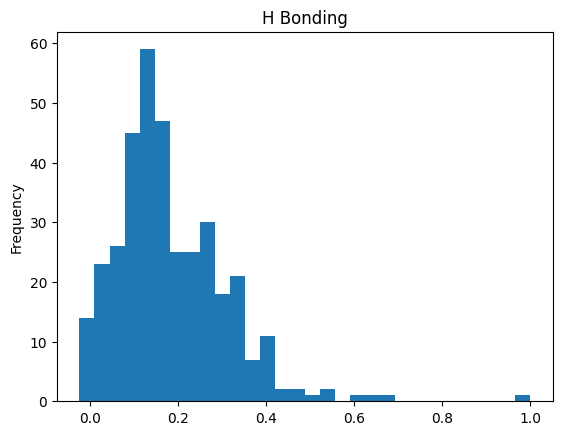

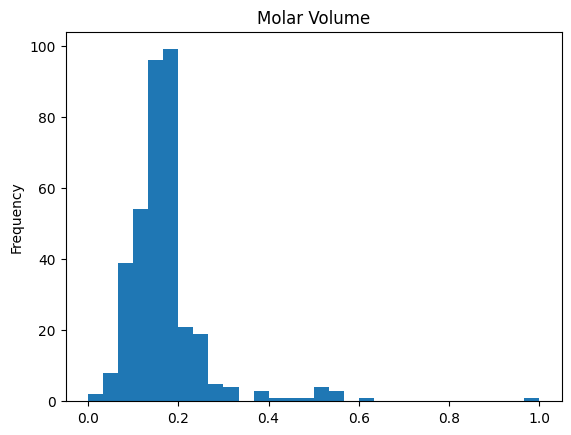

In [9]:
#columns_to_to_removed = ['Unnamed']
imputted_values = pd.read_csv(r'C:\Users\dadab\comp_data\scaled_imputted_data_1.csv',index_col = [0])
for i in imputted_values:
    fig, ax = plt.subplots()
    hist = imputted_values.hist(i, bins = 30, ax=ax)
    #if i is 'Viscosity':
      #  plt.xlim()
    plt.grid(False)
    plt.ylabel("Frequency")
    plt.show()
    fig.savefig('second_histograms' + i + '.png', bbox_inches = 'tight')

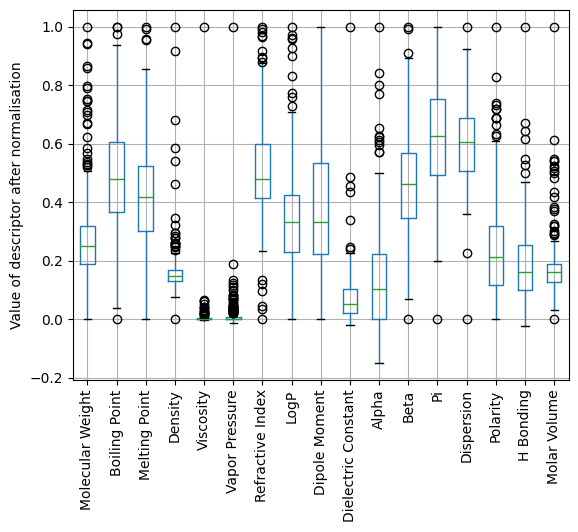

In [12]:
imputted_values = pd.DataFrame(df_imputed, columns = imputted_values.columns)
fig, ax = plt.subplots()
imputted_values.boxplot(column = list(imputted_values.columns), rot = 90, figsize =(9,9))
plt.ylabel("Value of descriptor after normalisation")
plt.show()
fig.savefig('second_boxplots_scaled_1_1'+ '.png',bbox_inches = 'tight')

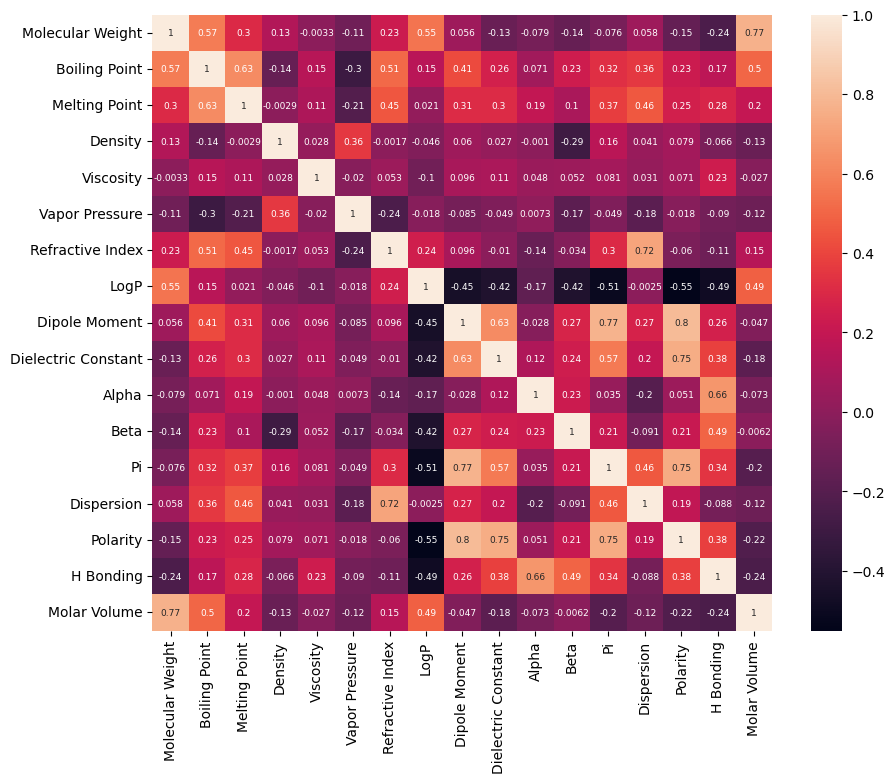

In [21]:
heatmap_data = imputted_values.corr()

fig, ax  = plt.subplots(figsize = (10, 8))

correlation_heatmap = sns.heatmap(heatmap_data, annot = True, annot_kws={"size": 6.5})

fig.savefig('imputted_data_heatmap.png', bbox_inches = 'tight')